In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from helperFxns import lett2num,alg2bin

In [2]:
## function definitions
def read_fasta(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    seqs = []
    for line in lines:
        if line[0] != '>':
            seqs.append(line.strip())
    return seqs

def one_hot_tranform(seqs,lett2index=None,N_aa=21):
    #convert to numbers
    _num = lett2num(seqs,lett2index=lett2index)
    # convert to one-hot 
    ## dimension M * (N_aa * L)
    seqs_one_hot = alg2bin(_num,N_aa=N_aa).toarray()
    return seqs_one_hot

In [3]:
# process data
A_filtered_seqs  = read_fasta('A_filtered.fasta')
A_filtered_one_hot = one_hot_tranform(A_filtered_seqs)
A_filtered_one_hot_3d = A_filtered_one_hot.reshape(A_filtered_one_hot.shape[0],-1,21).transpose(0, 2, 1)

In [4]:
A_filtered_one_hot_3d.shape

(3104, 21, 161)

# Part I: Compute mutual information within Proteins.
The definition of mutual information: \
$I(X;Y) = D_{KL}(P_{(X,Y)}||P_XP_Y)$ \
\
In the case of n amino acids at site X and m amino acids at site Y: \
$\sum^n_{j=1}\sum^m_{k=1}p_{jk}\log{\frac{p_{jk}}{p_jq_k}}$

In [7]:
def calculate_mutual_information(alignment):
    """
    The shape of input matrix should be (alignments, one_hot_encoding, positions)
    """
    # Determine the number of positions in the protein sequence
    num_positions = alignment.shape[2]  # Assuming alignment has shape (alignments, one_hot_encoding, positions)
    
    # Initialize the mutual information matrix
    mutual_information_matrix = np.zeros((num_positions, num_positions))
    
    # Calculate frequency for each position and each amino acid
    frequency = np.sum(alignment, axis=0) / alignment.shape[0]
    
    # Iterate over all unique pairs of positions
    for i in range(num_positions):
        for j in range(i+1, num_positions):
            # Calculate joint probabilities p_jk
            joint_probabilities = np.dot(alignment[:, :, i].T, alignment[:, :, j]) / alignment.shape[0]
            
            # Marginal probabilities for the positions
            p_i = frequency[:, i].reshape(-1, 1)
            p_j = frequency[:, j].reshape(1, -1)
            
            # Calculate mutual information for position pair (i, j)
            with np.errstate(divide='ignore', invalid='ignore'):
                log_term = np.log2(joint_probabilities / (p_i @ p_j))
                log_term[np.isinf(log_term) | np.isnan(log_term)] = 0  # Replace inf and NaN with 0
                mutual_information = np.sum(joint_probabilities * log_term)
            
            # Store the calculated mutual information
            mutual_information_matrix[i, j] = mutual_information
            mutual_information_matrix[j, i] = mutual_information  # Mutual information is symmetric
    
    return mutual_information_matrix

def process_aa(dataset):
    """
    This function takes in a dataset and returns the mutual information matrix between the amino acids.

    datasets: str, the name of the dataset, for example 'A_filtered.fasta'
    """
    seqs = read_fasta(dataset)
    one_hot = one_hot_tranform(seqs)
    one_hot_3d = one_hot.reshape(one_hot.shape[0],-1,21).transpose(0, 2, 1)
    mi = calculate_mutual_information(one_hot_3d)
    return mi

In [17]:
data_sets = ['A_filtered.fasta', 'B_filtered.fasta', 'C_filtered.fasta', 'D_filtered.fasta']
data_sets_name = ['A', 'B', 'C', 'D']
mi_dict = {}
for (i,data_set), name in zip(enumerate(data_sets), data_sets_name):
    mi = process_aa(data_set)
    mi_dict[name] = mi

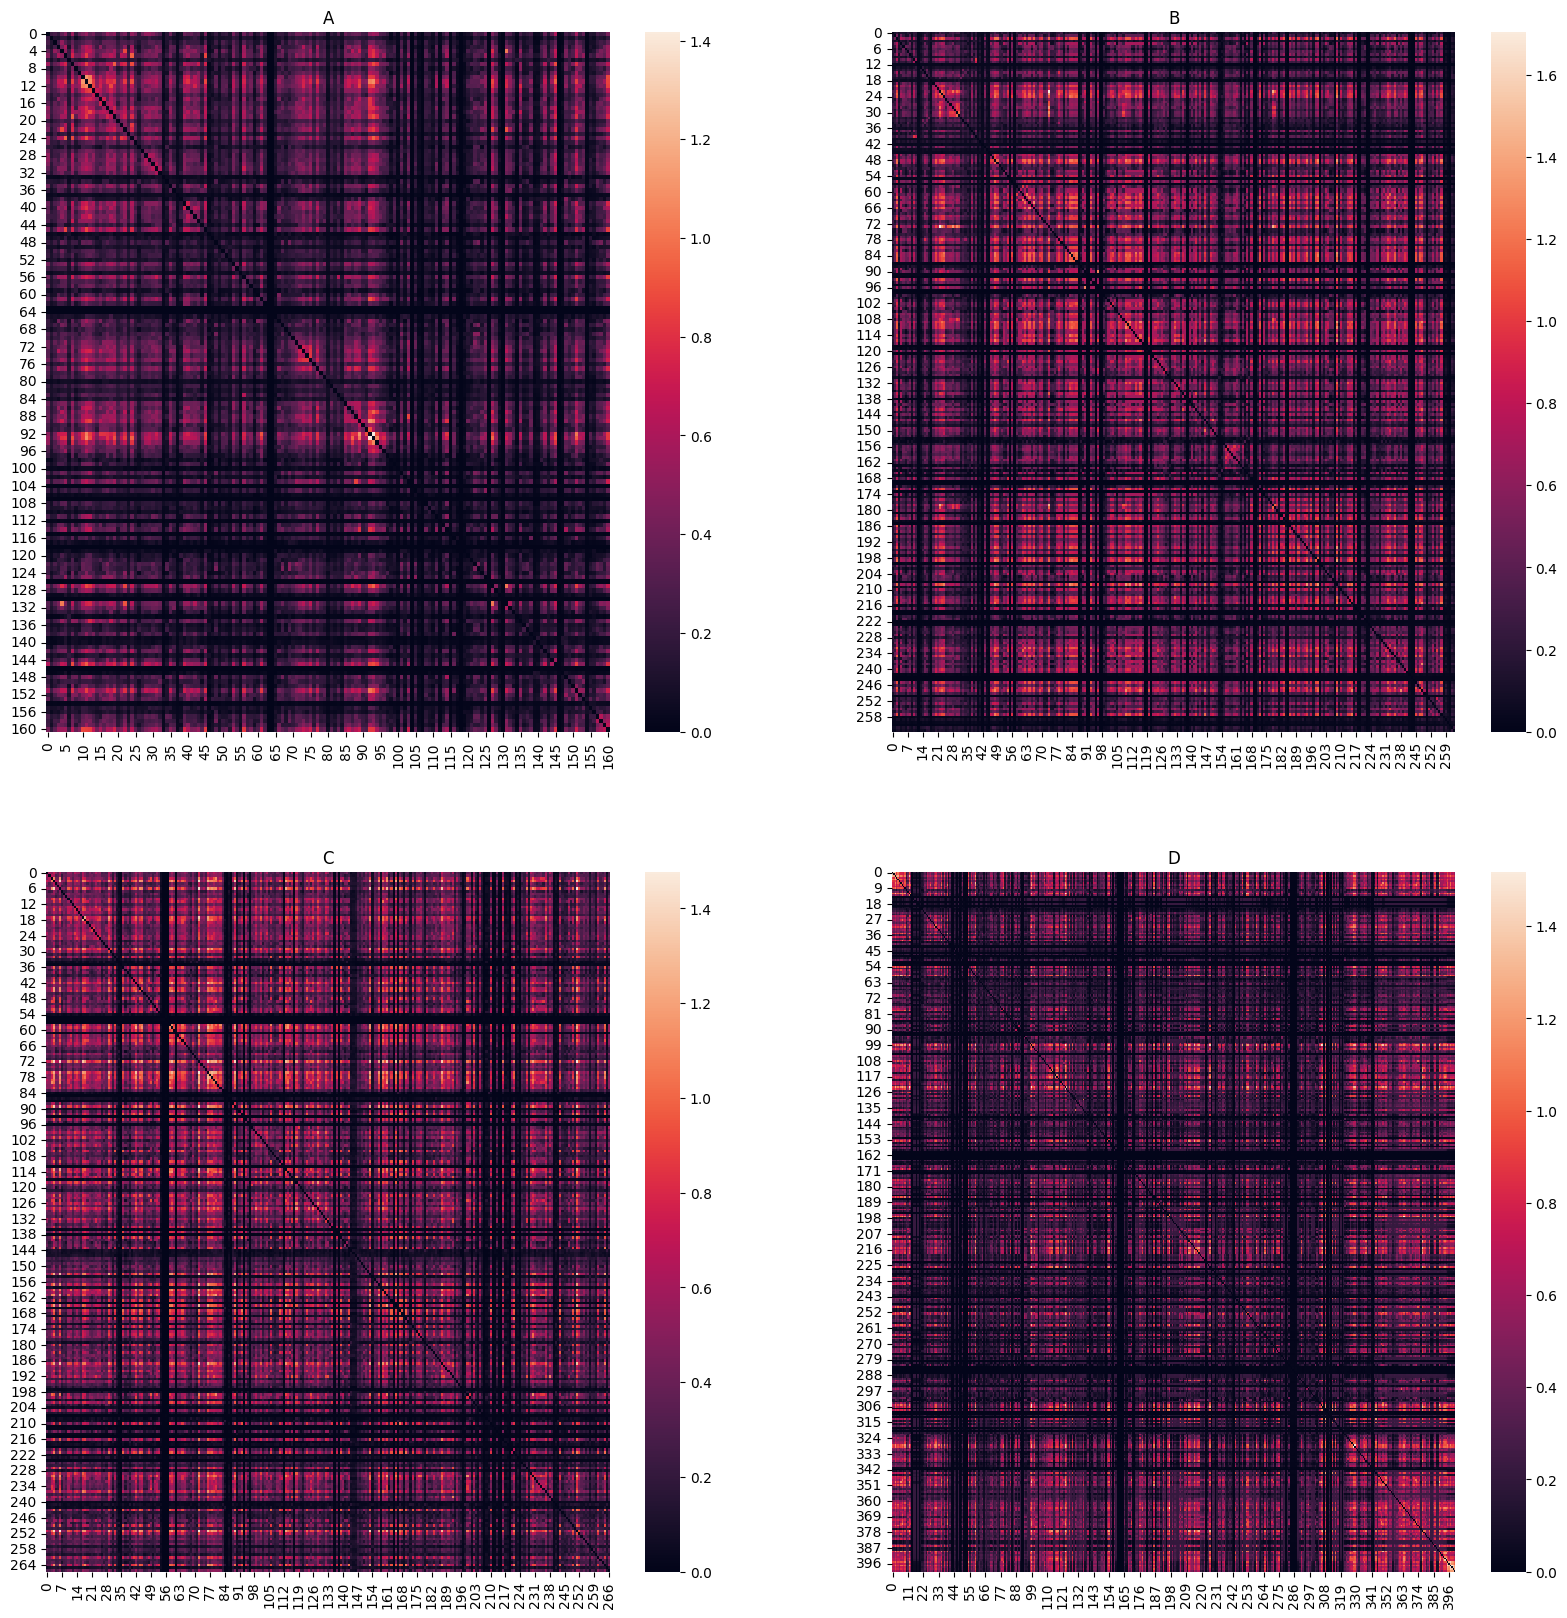

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for (i, (name, mi)), ax in zip(enumerate(mi_dict.items()), axes.flatten()):
    sns.heatmap(mi, ax=ax)
    ax.set_title(name)

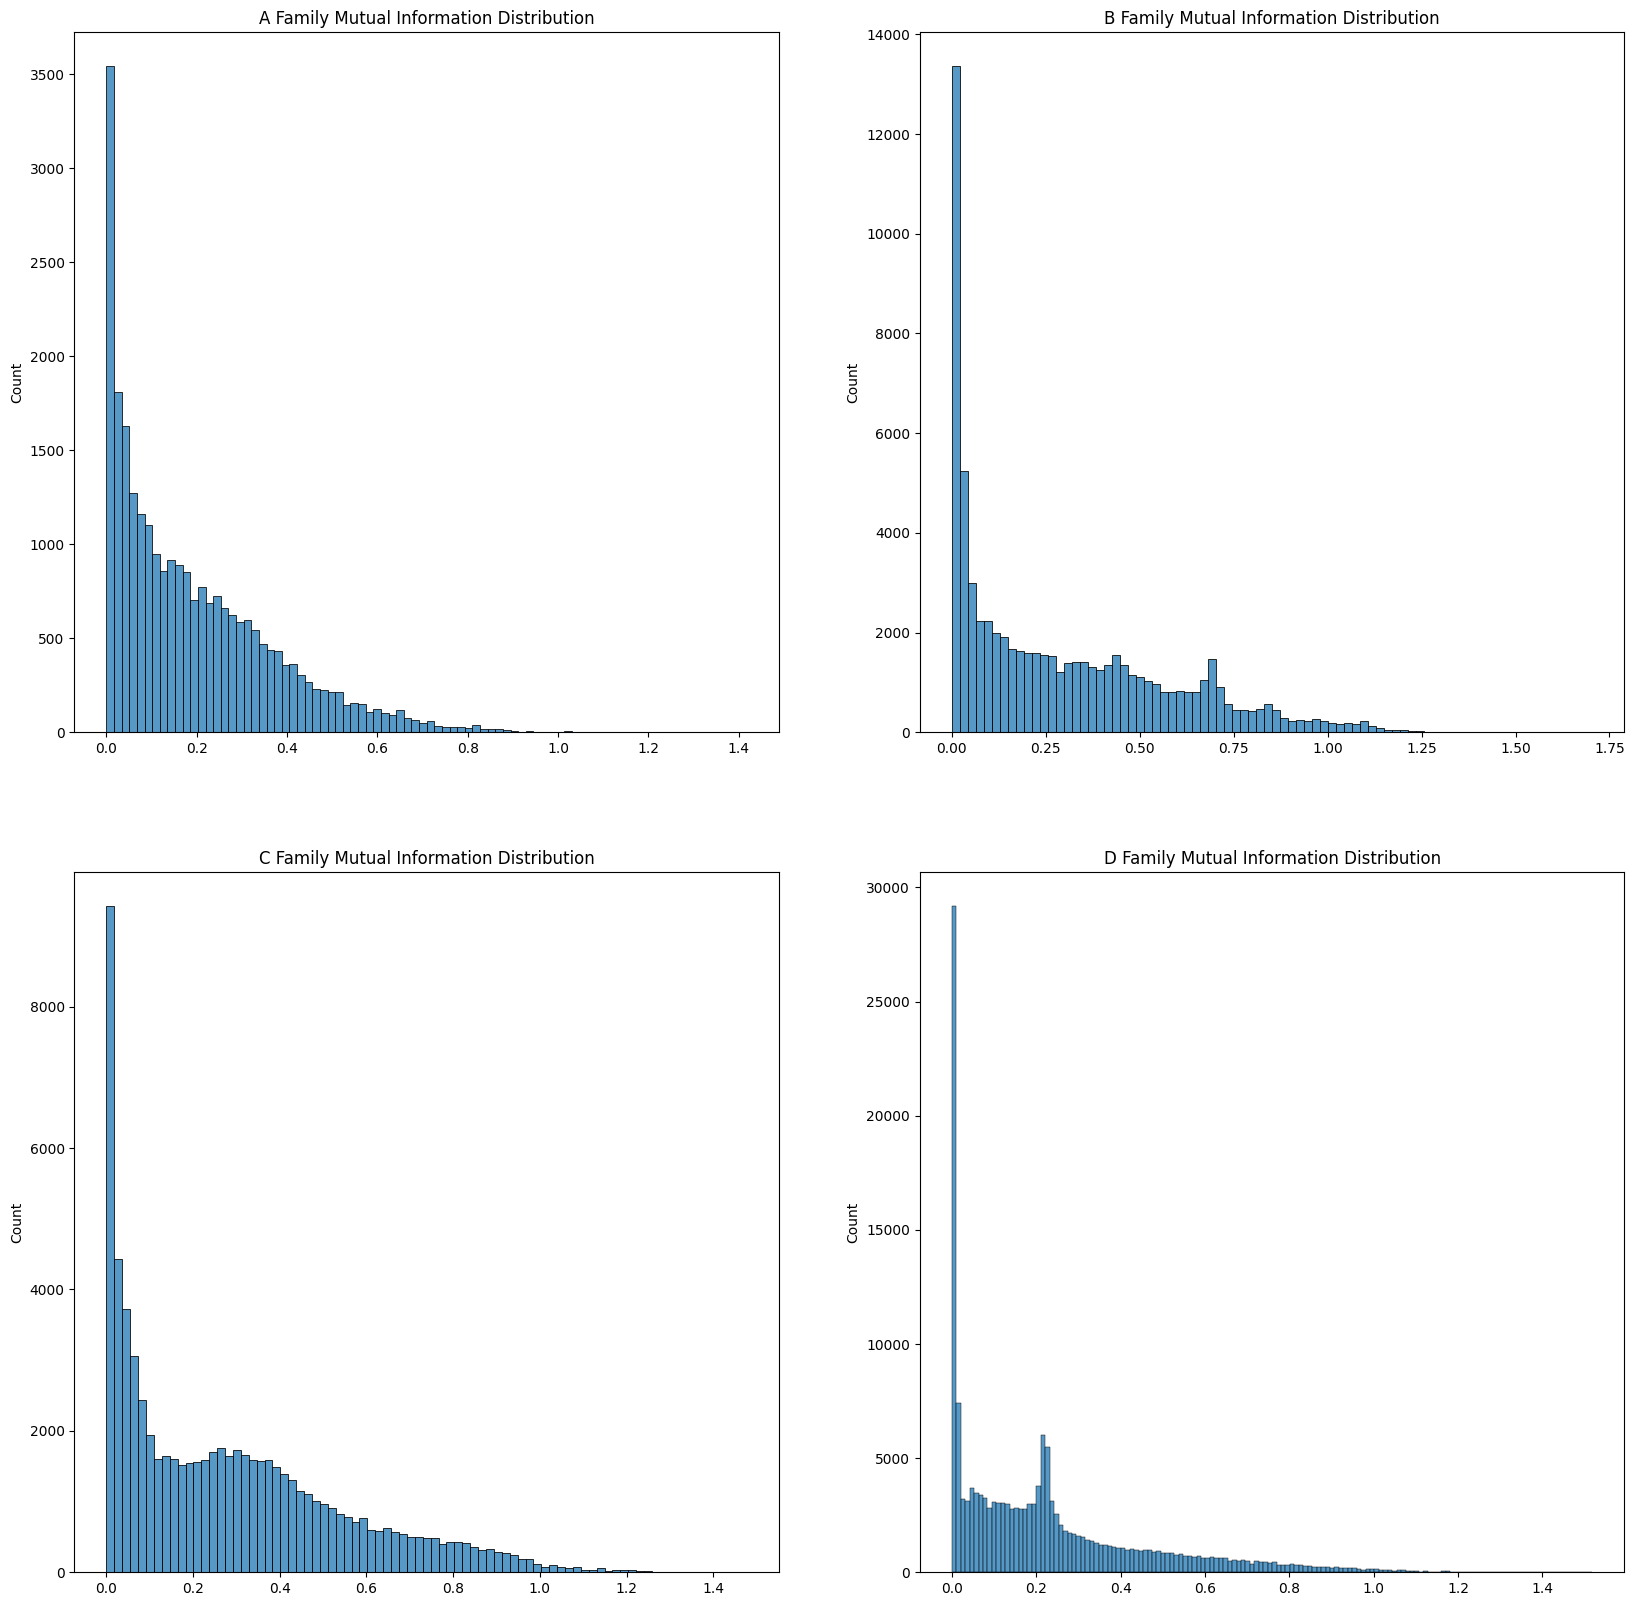

In [24]:
## plot the histogram for Fro norm method
fig,axes = plt.subplots(2,2, figsize=(20,20))
for (i, (name, mi)), ax in zip(enumerate(mi_dict.items()), axes.flatten()):
    sns.histplot(mi.flatten(), ax=ax)
    ax.set_title(f'{name} Family Mutual Information Distribution')

## Mutual Information between Physiachemical Property Group

In [25]:
## convert the specified amino type to physiochemical properties
## https://en.wikipedia.org/wiki/Amino_acid
## Polar: 1, Non-Polar: 2, Positively Charged: 3, Negatively Charged: 4, Blanks('-'): 5
lett2index = {'S': 1, 'T': 1, 'N': 1, 'Q': 1, 'C': 1, 'Y': 1,
                'A': 2, 'V': 2, 'L': 2, 'I': 2, 'M': 2, 'P': 2, 'F': 2, 'W': 2, 'G': 2,
                'K': 3, 'R': 3, 'H': 3,
                'D': 4, 'E': 4,
                '-': 5}

In [27]:
def process_class(dataset):
    """
    This function takes in a dataset and returns the mutual information matrix, 
    with amino acid type converted to physiochemical properties.

    datasets: str, the name of the dataset, for example 'A_filtered.fasta'
    """
    seqs = read_fasta(dataset)
    one_hot = one_hot_tranform(seqs,lett2index=lett2index,N_aa=5)
    one_hot_3d = one_hot.reshape(one_hot.shape[0],-1, 5).transpose(0, 2, 1)
    mi = calculate_mutual_information(one_hot_3d)
    return mi

In [28]:
mi_dict_class = {}
for (i,data_set), name in zip(enumerate(data_sets), data_sets_name):
    mi = process_class(data_set)
    mi_dict_class[name] = mi

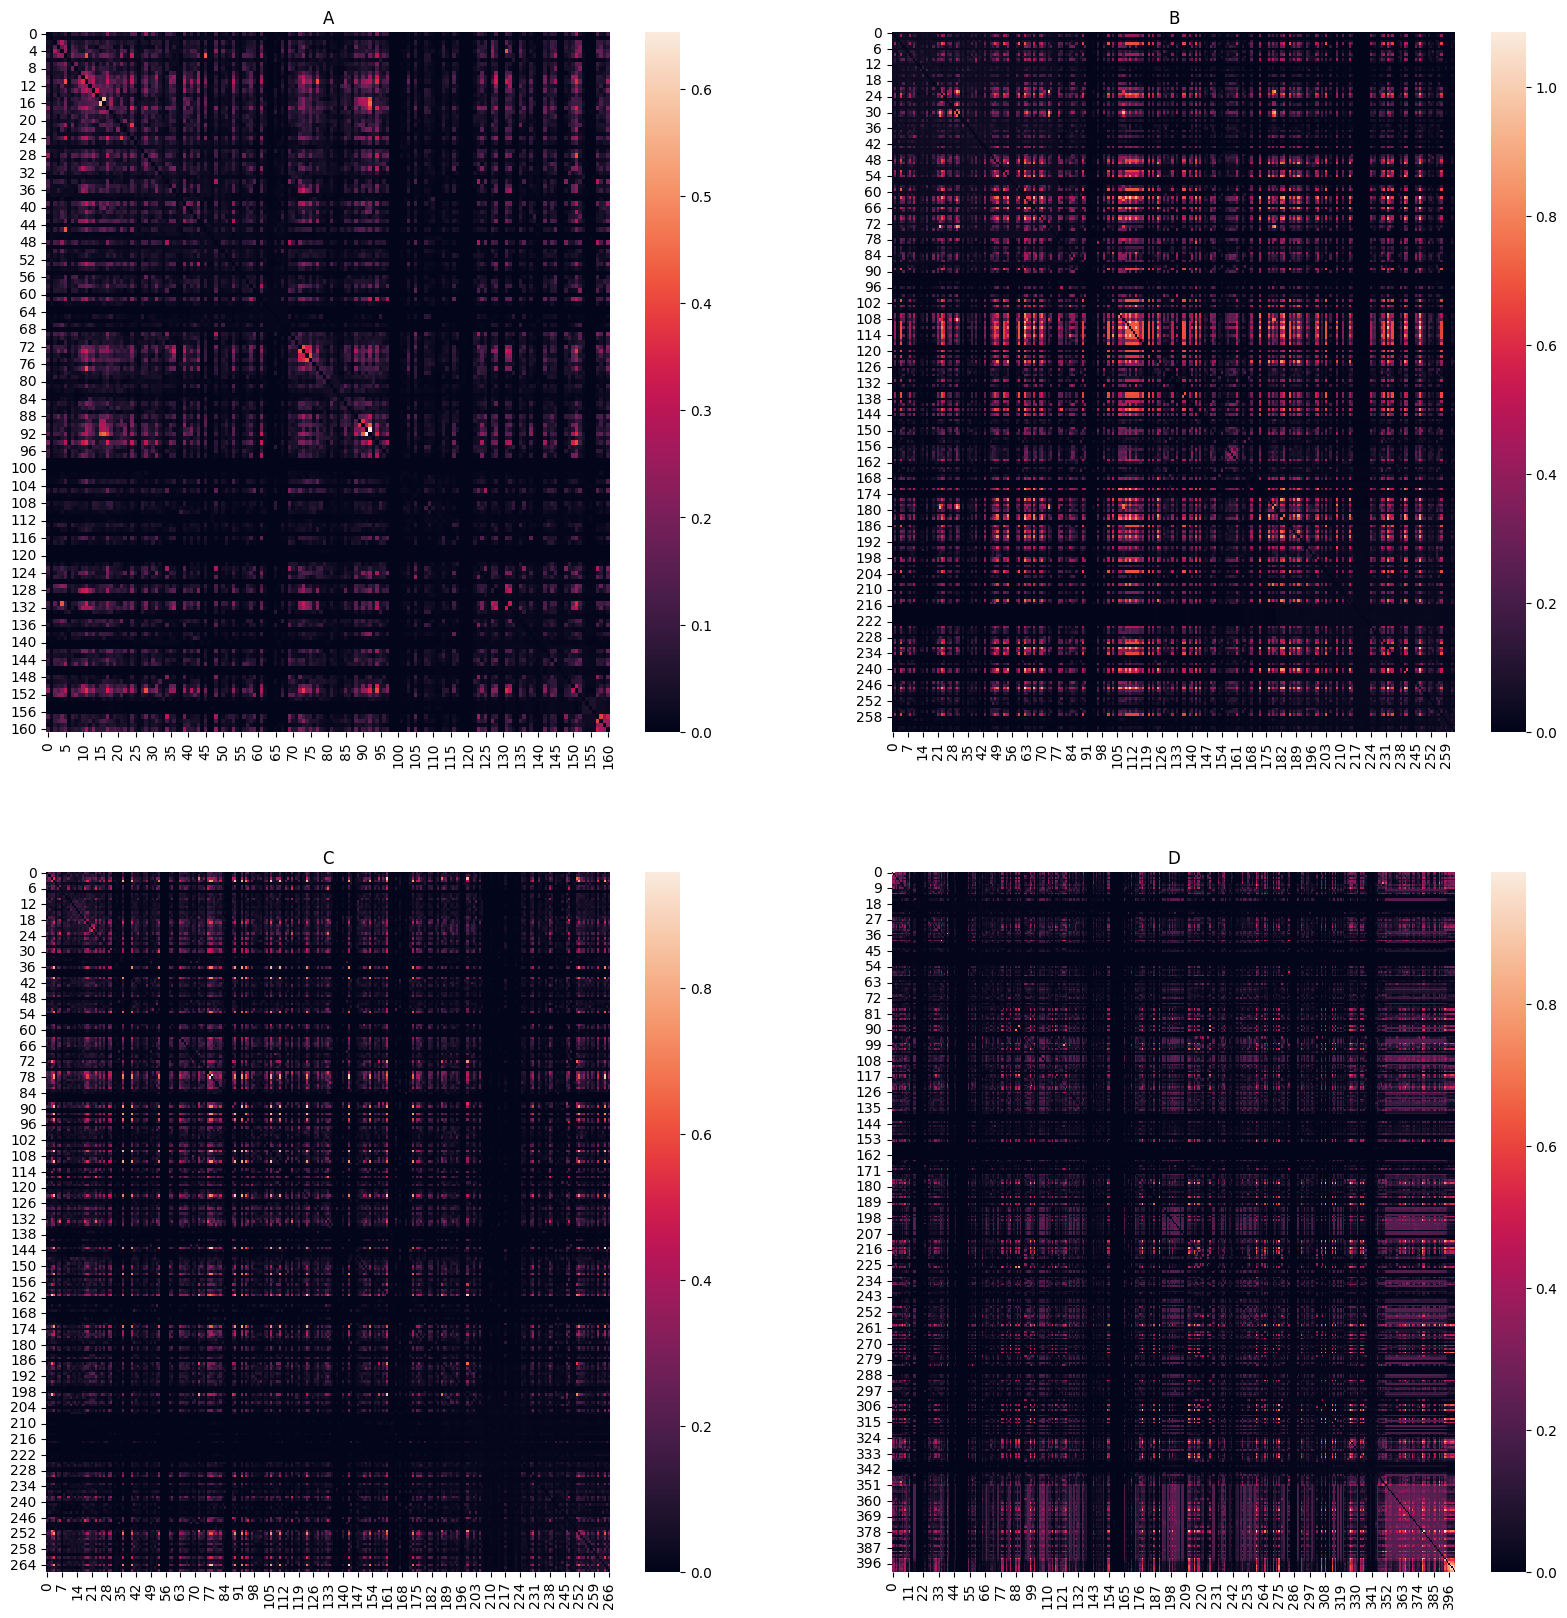

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for (i, (name, mi)), ax in zip(enumerate(mi_dict_class.items()), axes.flatten()):
    sns.heatmap(mi, ax=ax)
    ax.set_title(name)

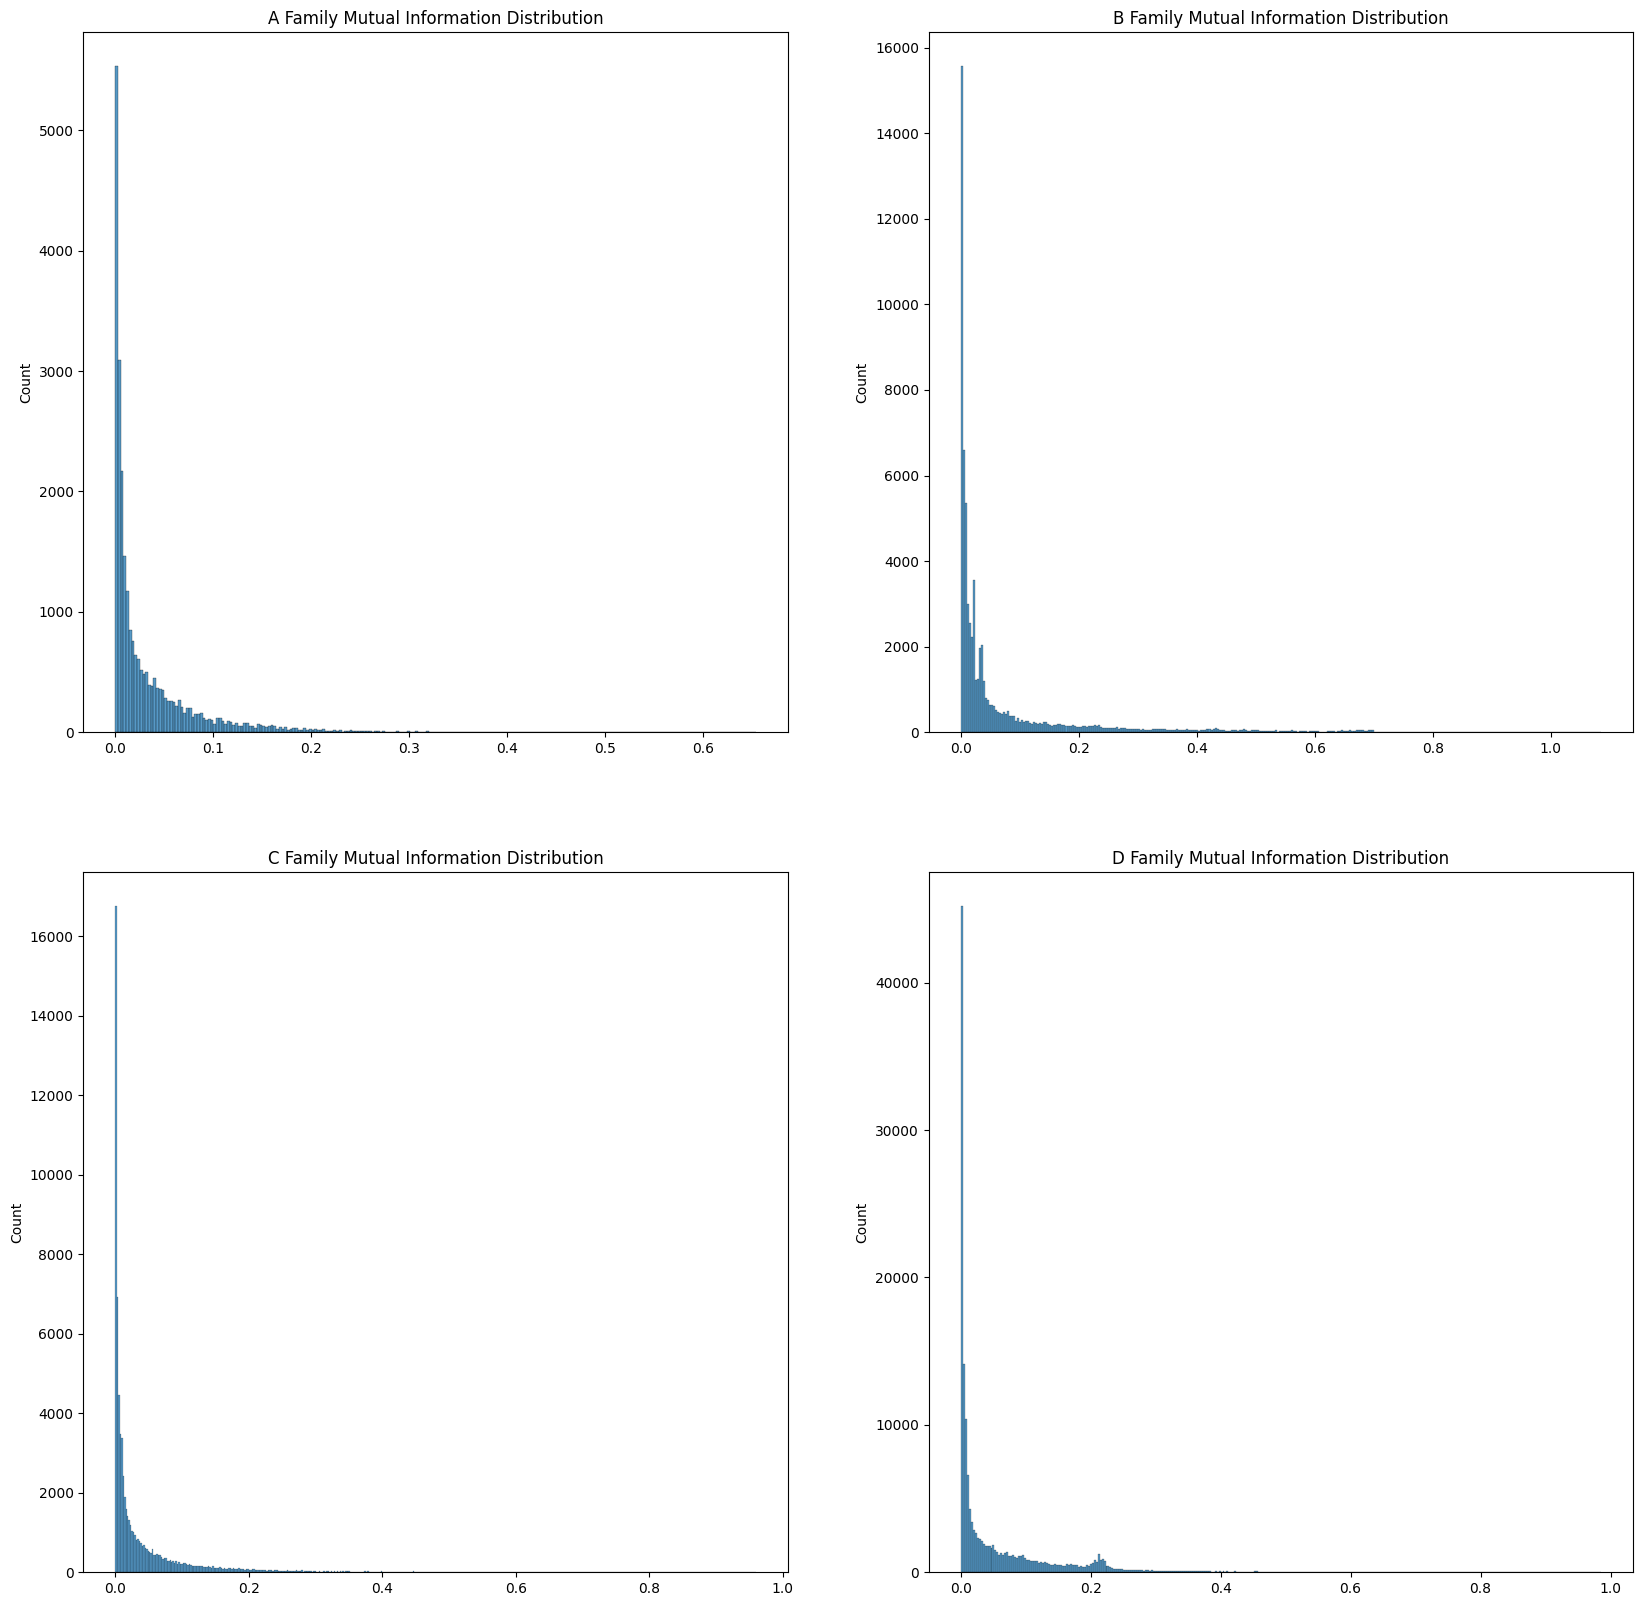

In [30]:
## plot the histogram for Fro norm method
fig,axes = plt.subplots(2,2, figsize=(20,20))
for (i, (name, mi)), ax in zip(enumerate(mi_dict_class.items()), axes.flatten()):
    sns.histplot(mi.flatten(), ax=ax)
    ax.set_title(f'{name} Family Mutual Information Distribution')

# Part II: Concatenation based on the species

In [31]:
import pandas as pd
from Bio import SeqIO

def fasta_to_dataframe(fasta_file,family_name='A'):
    records = list(SeqIO.parse(fasta_file, "fasta"))
    data = {f"Description_{family_name}": [record.description for record in records],
            f"Sequence_{family_name}": [str(record.seq) for record in records]}
    df = pd.DataFrame(data)
    return df

In [32]:
df_A = fasta_to_dataframe('A_filtered.fasta')
df_A

,Description_A,Sequence_A
0,"Prot: A, level_taxid: 1236, organism taxid: ""1...",ALTYTQYSHSPNG------NKGWVLHFH-VPIAPAYVTGQPEVLIT...
1,"Prot: A, level_taxid: 1236, organism taxid: ""1...",KTVFTQYSYSPNE------NKVWVLKFRDTPIKPGYVDGIVNVLVT...
2,"Prot: A, level_taxid: 1236, organism taxid: ""9...",KVVFTQYSYSPSE------NKVWVLKYRSTPIKPGFVDGIANVLVT...
3,"Prot: A, level_taxid: 1236, organism taxid: ""1...",TRQWYSVTFSGKD----GKM-EYLAHLDVFFTKPLVTDVDGSFDIE...
4,"Prot: A, level_taxid: 1236, organism taxid: ""6...",RRNFLRTVFKSHQ----VVDKDW-DWE-KADFPPFYVNGEYPDRIF...
...,...,...
3099,"Prot: A, level_taxid: 1236, organism taxid: ""1...",RRELTLFRFAHSHRDDAYHAEDAITEWDARDFRPFFAD--VDADIE...
3100,"Prot: A, level_taxid: 1236, organism taxid: ""1...",RRELTLFRFAHSHRDDARHAEDALTEWDARDYRPFFAD--VDADIE...
3101,"Prot: A, level_taxid: 1236, organism taxid: ""4...",RRILTVFSYDFLHKEDKLKKERAVEQWEEEVLAPFFAD--IHAHVI...
3102,"Prot: A, level_taxid: 1236, organism taxid: ""2...",QRVFESITFSYAHDEDPEHRENRIRSWGAWNIDPFSVD--IVAEIQ...


In [33]:
import re
org_id_pattern = r"organism\s+taxid:\s*\"(\d+(?:_\d+)?)\""
df_A['organism_taxid'] = df_A['Description_A'].str.extract(org_id_pattern, flags=re.IGNORECASE)

In [34]:
df_A

,Description_A,Sequence_A,organism_taxid
0,"Prot: A, level_taxid: 1236, organism taxid: ""1...",ALTYTQYSHSPNG------NKGWVLHFH-VPIAPAYVTGQPEVLIT...,1513468_0
1,"Prot: A, level_taxid: 1236, organism taxid: ""1...",KTVFTQYSYSPNE------NKVWVLKFRDTPIKPGYVDGIVNVLVT...,1513468_0
2,"Prot: A, level_taxid: 1236, organism taxid: ""9...",KVVFTQYSYSPSE------NKVWVLKYRSTPIKPGFVDGIANVLVT...,932213_0
3,"Prot: A, level_taxid: 1236, organism taxid: ""1...",TRQWYSVTFSGKD----GKM-EYLAHLDVFFTKPLVTDVDGSFDIE...,1736226_0
4,"Prot: A, level_taxid: 1236, organism taxid: ""6...",RRNFLRTVFKSHQ----VVDKDW-DWE-KADFPPFYVNGEYPDRIF...,675524_0
...,...,...,...
3099,"Prot: A, level_taxid: 1236, organism taxid: ""1...",RRELTLFRFAHSHRDDAYHAEDAITEWDARDFRPFFAD--VDADIE...,163359_0
3100,"Prot: A, level_taxid: 1236, organism taxid: ""1...",RRELTLFRFAHSHRDDARHAEDALTEWDARDYRPFFAD--VDADIE...,1281578_0
3101,"Prot: A, level_taxid: 1236, organism taxid: ""4...",RRILTVFSYDFLHKEDKLKKERAVEQWEEEVLAPFFAD--IHAHVI...,437022_0
3102,"Prot: A, level_taxid: 1236, organism taxid: ""2...",QRVFESITFSYAHDEDPEHRENRIRSWGAWNIDPFSVD--IVAEIQ...,2315472_2


In [35]:
df_A['organism_taxid'].value_counts()

organism_taxid
2027290_0     4
1513468_0     3
2589817_0     3
208224_0      3
2041079_0     3
             ..
1736576_0     1
1896164_0     1
743721_0      1
314722_0      1
2315472_24    1
Name: count, Length: 3022, dtype: int64

In [36]:
df_A['gapped_freq'] = df_A.apply(lambda x: x['Sequence_A'].count('-')/len(x['Sequence_A']), axis=1)
df_A

,Description_A,Sequence_A,organism_taxid,gapped_freq
0,"Prot: A, level_taxid: 1236, organism taxid: ""1...",ALTYTQYSHSPNG------NKGWVLHFH-VPIAPAYVTGQPEVLIT...,1513468_0,0.099379
1,"Prot: A, level_taxid: 1236, organism taxid: ""1...",KTVFTQYSYSPNE------NKVWVLKFRDTPIKPGYVDGIVNVLVT...,1513468_0,0.099379
2,"Prot: A, level_taxid: 1236, organism taxid: ""9...",KVVFTQYSYSPSE------NKVWVLKYRSTPIKPGFVDGIANVLVT...,932213_0,0.099379
3,"Prot: A, level_taxid: 1236, organism taxid: ""1...",TRQWYSVTFSGKD----GKM-EYLAHLDVFFTKPLVTDVDGSFDIE...,1736226_0,0.086957
4,"Prot: A, level_taxid: 1236, organism taxid: ""6...",RRNFLRTVFKSHQ----VVDKDW-DWE-KADFPPFYVNGEYPDRIF...,675524_0,0.062112
...,...,...,...,...
3099,"Prot: A, level_taxid: 1236, organism taxid: ""1...",RRELTLFRFAHSHRDDAYHAEDAITEWDARDFRPFFAD--VDADIE...,163359_0,0.049689
3100,"Prot: A, level_taxid: 1236, organism taxid: ""1...",RRELTLFRFAHSHRDDARHAEDALTEWDARDYRPFFAD--VDADIE...,1281578_0,0.049689
3101,"Prot: A, level_taxid: 1236, organism taxid: ""4...",RRILTVFSYDFLHKEDKLKKERAVEQWEEEVLAPFFAD--IHAHVI...,437022_0,0.031056
3102,"Prot: A, level_taxid: 1236, organism taxid: ""2...",QRVFESITFSYAHDEDPEHRENRIRSWGAWNIDPFSVD--IVAEIQ...,2315472_2,0.018634


In [37]:
df_A_sorted = df_A.sort_values(by='gapped_freq', ascending=True)
df_A_unique = df_A_sorted.drop_duplicates(subset='organism_taxid', keep='first')
df_A_unique.reset_index(inplace=True,drop=True)
df_A_unique

,Description_A,Sequence_A,organism_taxid,gapped_freq
0,"Prot: A, level_taxid: 1236, organism taxid: ""2...",ARRYDVFDFAFAHREDAAHHERAVEVWLAPDVPPFHTDAPVTTQVW...,216778_1,0.000000
1,"Prot: A, level_taxid: 1236, organism taxid: ""8...",LRLYDLFEFAFENREDAAHAERAVVRWEAADFRPFFADAEVETDVR...,84531_0,0.000000
2,"Prot: A, level_taxid: 1236, organism taxid: ""6...",LRVYDVYEFDFENREDARHSERATERWEASDFRPFFADAEVVTDVR...,69_1,0.000000
3,"Prot: A, level_taxid: 1236, organism taxid: ""6...",LRVYDVYEFDFENREDARHRERATERWEAPDLRPFFADAAVETDVR...,69_0,0.000000
4,"Prot: A, level_taxid: 1236, organism taxid: ""7...",RRRYDVFDFAFAHRADAPHRERAVPEWEAADIAPFFADAEVEAAVH...,701189_0,0.000000
...,...,...,...,...
3017,"Prot: A, level_taxid: 1236, organism taxid: ""2...",IRRYTIFSYDYPNKE--THPEHQSQKWVTKDLPPFSADG-VETDIK...,2340_0,0.124224
3018,"Prot: A, level_taxid: 1236, organism taxid: ""1...",RRVLNVFAYDYANKE--SHNQRAVEQWEQWDIEPFRVDG-VDADVL...,1818881_0,0.124224
3019,"Prot: A, level_taxid: 1236, organism taxid: ""2...",NEQYDKENFIFKKCEANVLDVETLI-----------------LDTL...,2028576_0,0.136646
3020,"Prot: A, level_taxid: 1236, organism taxid: ""9...",DEFYRSPFRTLIGE---RKRVYTLM-----------------IEDV...,990268_2,0.273292


In [38]:
protein_families = ['A','B','C','D']
dfs = []
for fa in protein_families:
    df = fasta_to_dataframe(f"{fa}_filtered.fasta",family_name=fa)
    df['organism_tax_id'] = df[f'Description_{fa}'].str.extract(org_id_pattern, flags=re.IGNORECASE)
    df['gapped_freq'] = df.apply(lambda x: x[f'Sequence_{fa}'].count('-')/len(x[f'Sequence_{fa}']), axis=1)
    df_sorted = df.sort_values(by='gapped_freq', ascending=True)
    df_unique = df_sorted.drop_duplicates(subset='organism_tax_id', keep='first')
    df_unique.reset_index(inplace=True,drop=True)
    dfs.append(df_unique[['organism_tax_id',f'Sequence_{fa}']])

In [39]:
from functools import reduce
df = reduce(lambda x, y: pd.merge(x, y, on='organism_tax_id', how='inner'), dfs)
df['Sequence'] = df.apply(lambda x: ''.join([x[f'Sequence_{fa}'] for fa in protein_families]), axis=1)
df

,organism_tax_id,Sequence_A,Sequence_B,Sequence_C,Sequence_D,Sequence
0,216778_1,ARRYDVFDFAFAHREDAAHHERAVEVWLAPDVPPFHTDAPVTTQVW...,VAVPAKIAPHPDYGDIRIDDFQFGFLDTVDPNLWLNPLARPERALQ...,AADLARRLPTLFAQATAAAA---DPAEGLAAVLASGVVVGDAEVAM...,--LVLGERAAITHVDKDGRGSLNCLVLKDRPLDRAIKIAQAVAHSS...,ARRYDVFDFAFAHREDAAHHERAVEVWLAPDVPPFHTDAPVTTQVW...
1,84531_0,LRLYDLFEFAFENREDAAHAERAVVRWEAADFRPFFADAEVETDVR...,VAVPAKIAPLPDYGEIAIDDYSFGFVDKIEPNLKLKPLARPTRSLQ...,-GDLAQRLPTLFRRAAQAAA---DTTPALEAVLASGVVVGDAERAM...,--FHLGERGAITHVDKDGRGSLNCLVVQDKPMSRALKIAQAIAHSS...,LRLYDLFEFAFENREDAAHAERAVVRWEAADFRPFFADAEVETDVR...
2,69_1,LRVYDVYEFDFENREDARHSERATERWEASDFRPFFADAEVVTDVR...,VAVPAKIAPLPDYGEIAIDEYGFAFLDSVDPNLKLRPLARPERALQ...,HRDLARRLPALFERAAQAAA---SAAEALVAVLASGVVVGEAERAM...,--FHLGERGAITHVDKDGRGSLNCLVVQDKPMSRALKIAQAIAHSS...,LRVYDVYEFDFENREDARHSERATERWEASDFRPFFADAEVVTDVR...
3,69_0,LRVYDVYEFDFENREDARHRERATERWEAPDLRPFFADAAVETDVR...,VAVPAKIAPAPDYGEIAIDDYGFAFLDTVTPDLKLRPLARPARALQ...,AADLAARLPALFDRAAQAAA---SAAEALVAVLASGVVVGEAERAM...,--FHLGERGAITHVDKDGRGSLNCLVVQDKPMSRALKIAQAIAHSS...,LRVYDVYEFDFENREDARHRERATERWEAPDLRPFFADAAVETDVR...
4,701189_0,RRRYDVFDFAFAHRADAPHRERAVPEWEAADIAPFFADAEVEAAVH...,VAVPAKIAPHPDYGEIAIDDFGFAFLDSVAPNLRLKPLPRPARSLQ...,GADLAARLPALFAEARQRAT---DGAEALAAVLASGVVVGDADVAM...,--FVIGERAAITHVDKDGRGSLNCLVLADKPLDRALKIAQAVAHSS...,RRRYDVFDFAFAHRADAPHRERAVPEWEAADIAPFFADAEVEAAVH...
...,...,...,...,...,...,...
2889,141949_0,--------VTRPHTGL--HHHRATGGWGGPPPPPFFGGGGGGTGFP...,VAVPAKIAPWPDYGEIVVDEYRFGFIDRVDPNLKLVPLPRPTRALQ...,TGDLAARLPHLFAGARAAAT---DPSADLAAVLASGVVVGDAHAAM...,--LSLGERAAITHVDKDGRGSLNCLVLADRPLERALKIAQAVAHSS...,--------VTRPHTGL--HHHRATGGWGGPPPPPFFGGGGGGTGFP...
2890,2301224_0,GREFTAFVLNYPNAD--PRSAMKTLRWDSASWEPFVTDG-VVADIL...,VAIPARIAPHCQYGELRFDEYVFDRLRARRNVLHMRPAPYPERSLQ...,NNDMAERVPALYERAADV--AAPSDTKGLREVLASGIVVADASEAA...,--LTMGELEAVTNIDKDGRGSLNVLVIEDKSRGAALKMGYAVAHAS...,GREFTAFVLNYPNAD--PRSAMKTLRWDSASWEPFVTDG-VVADIL...
2891,2340_0,IRRYTIFSYDYPNKE--THPEHQSQKWVTKDLPPFSADG-VETDIK...,IAVPAKIHPHCQYDVVEFDDFSFEFLDKIDPNIRMSPLAFPTRSLQ...,RTQLASSLETVFEGVVRDV--LSAAEAEIRSVIASGVVVADAIEAM...,--LEIGELSAVTHMDKDGRGSLNVLINQEKSMTPALKRAYALAHSS...,IRRYTIFSYDYPNKE--THPEHQSQKWVTKDLPPFSADG-VETDIK...
2892,1818881_0,RRVLNVFAYDYANKE--SHNQRAVEQWEQWDIEPFRVDG-VDADVL...,VAVPAKIHPHPDYDTLEFDEFRFAFIDKVEPNISMGPLAKPERSLQ...,ANDMAQRMNSLLERLAAGI--PQDALAEVRSVLASGVVVADAVQSV...,--IKLGEQAAVTHMDKDGRGSLNVLVIQDRRMTQALKAAYALAHSS...,RRVLNVFAYDYANKE--SHNQRAVEQWEQWDIEPFRVDG-VDADVL...


In [40]:
def process_species(seqs):
    one_hot = one_hot_tranform(seqs)
    one_hot_3d = one_hot.reshape(one_hot.shape[0],-1,21).transpose(0, 2, 1)
    mi = calculate_mutual_information(one_hot_3d)
    return mi

In [41]:
mi_species = process_species(df['Sequence'].to_list())

<Axes: >

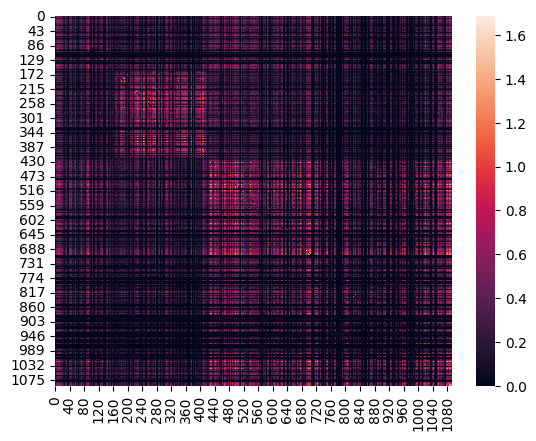

In [42]:
sns.heatmap(mi_species)

<Axes: ylabel='Count'>

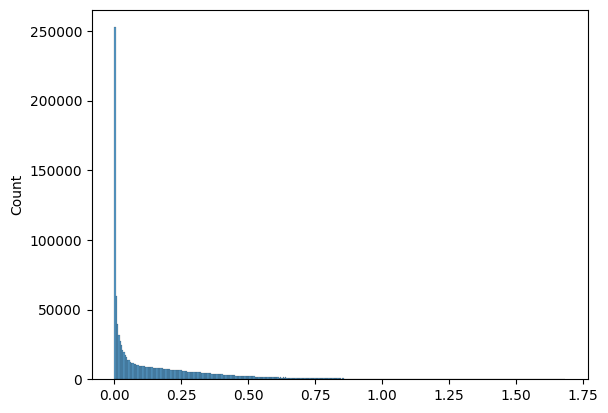

In [43]:
sns.histplot(mi_species.flatten())

<Axes: ylabel='Count'>

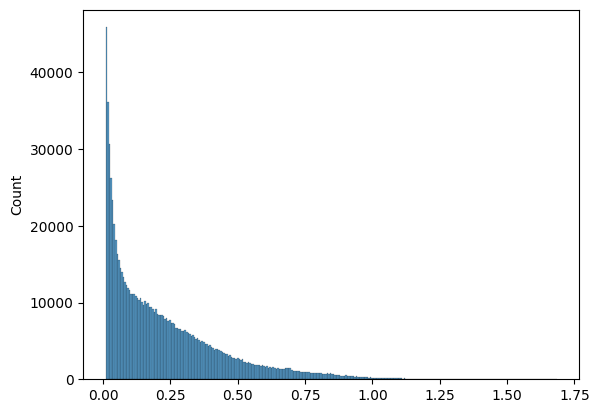

In [44]:
## test to remove the near-zero variance columns
sns.histplot(mi_species.flatten()[mi_species.flatten() > 1e-2])